Device: cpu

Training Multi-scale AE
Epoch 1/20 - loss 0.518789
Epoch 2/20 - loss 0.186273
Epoch 3/20 - loss 0.164294
Epoch 4/20 - loss 0.120474
Epoch 5/20 - loss 0.078939
Epoch 6/20 - loss 0.037114
Epoch 7/20 - loss 0.016418
Epoch 8/20 - loss 0.011246
Epoch 9/20 - loss 0.010437
Epoch 10/20 - loss 0.009724
Epoch 11/20 - loss 0.009195
Epoch 12/20 - loss 0.008742
Epoch 13/20 - loss 0.008050
Epoch 14/20 - loss 0.007174
Epoch 15/20 - loss 0.006290
Epoch 16/20 - loss 0.005418
Epoch 17/20 - loss 0.004999
Epoch 18/20 - loss 0.004129
Epoch 19/20 - loss 0.004000
Epoch 20/20 - loss 0.003709

Training Baseline AE
Epoch 1/20 - loss 0.445810
Epoch 2/20 - loss 0.163440
Epoch 3/20 - loss 0.091659
Epoch 4/20 - loss 0.037970
Epoch 5/20 - loss 0.019776
Epoch 6/20 - loss 0.015584
Epoch 7/20 - loss 0.013525
Epoch 8/20 - loss 0.011947
Epoch 9/20 - loss 0.010520
Epoch 10/20 - loss 0.009309
Epoch 11/20 - loss 0.008419
Epoch 12/20 - loss 0.007748
Epoch 13/20 - loss 0.006970
Epoch 14/20 - loss 0.006380
Epoch 1

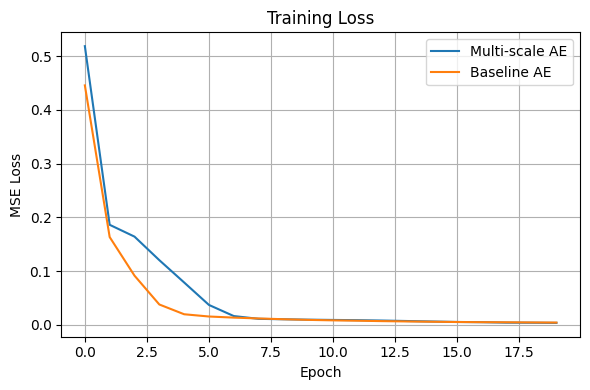

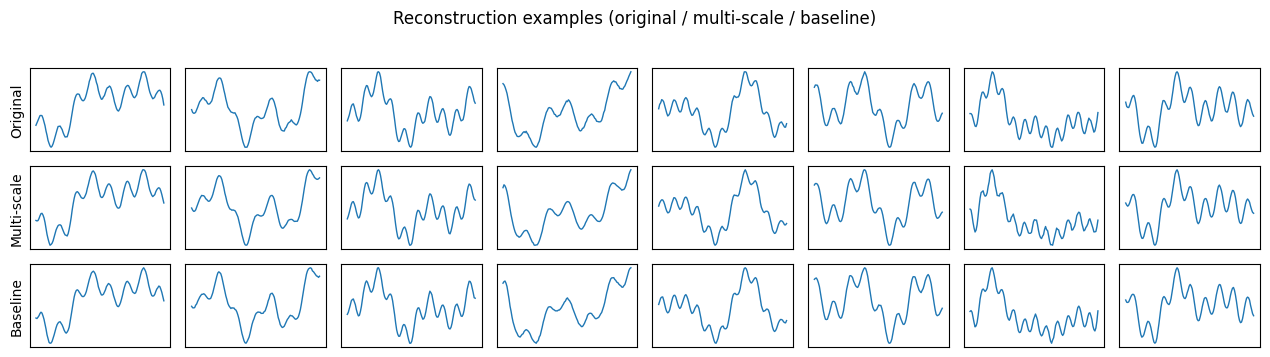

In [1]:


import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# -----------------------
# Settings
# -----------------------
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Output filenames (upload these to Overleaf)
OUT_RECON = "fig_reconstructions.png"
OUT_LOSS = "fig_loss.png"
MODEL_MS = "msae.pth"
MODEL_BASE = "baseae.pth"

# -----------------------
# Synthetic time-series dataset
# -----------------------
class MultiFreqSineDataset(Dataset):
    """
    Each sample is a mixture of multiple sines (short and long period),
    plus small noise. Length = seq_len timesteps.
    """
    def __init__(self, n_samples=5000, seq_len=128, n_components=(1,3),
                 short_freq_range=(3,8), long_freq_range=(0.5,2.5), noise_std=0.05):
        self.n_samples = n_samples
        self.seq_len = seq_len
        self.noise_std = noise_std
        self.short_k, self.long_k = n_components
        self.short_freq_range = short_freq_range
        self.long_freq_range = long_freq_range
        self.x = self._generate_all()

    def _generate_one(self):
        t = np.linspace(0, 1, self.seq_len, endpoint=False)
        signal = np.zeros_like(t)
        # long components (slow oscillations)
        for _ in range(self.long_k):
            f = np.random.uniform(*self.long_freq_range)
            phase = np.random.uniform(0, 2*np.pi)
            amp = np.random.uniform(0.5, 1.0)
            signal += amp * np.sin(2*np.pi*f*t + phase)
        # short components (fast details)
        for _ in range(self.short_k):
            f = np.random.uniform(*self.short_freq_range)
            phase = np.random.uniform(0, 2*np.pi)
            amp = np.random.uniform(0.2, 0.8)
            signal += amp * np.sin(2*np.pi*f*t + phase)
        # trend + noise
        trend = np.random.uniform(-0.2, 0.2) * t
        signal = signal + trend
        signal = (signal - signal.mean()) / (signal.std() + 1e-9)  # normalize
        signal = signal + np.random.normal(scale=self.noise_std, size=signal.shape)
        return signal.astype(np.float32)

    def _generate_all(self):
        return np.stack([self._generate_one() for _ in range(self.n_samples)])

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        # return as vector
        return self.x[idx]

# -----------------------
# Models
# -----------------------
class MultiScaleAutoencoder(nn.Module):
    """
    Multi-scale: short-term encoder + long-term encoder (different receptive fields)
    fuse latent -> decoder
    Input: [batch, seq_len]
    """
    def __init__(self, seq_len=128, latent_short=32, latent_long=32, hidden_dec=128):
        super().__init__()
        self.seq_len = seq_len
        in_dim = seq_len

        # Short-term encoder: small receptive field via shallow 1D convs
        self.enc_short = nn.Sequential(
            nn.Unflatten(1, (1, seq_len)),                 # [B,1,L]
            nn.Conv1d(1, 16, kernel_size=3, padding=1),    # [B,16,L]
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(16),                      # compress to 16 features
            nn.Flatten(),
            nn.Linear(32*16, 128),
            nn.ReLU(),
            nn.Linear(128, latent_short)
        )

        # Long-term encoder: larger receptive field via dilated convs
        self.enc_long = nn.Sequential(
            nn.Unflatten(1, (1, seq_len)),
            nn.Conv1d(1, 16, kernel_size=7, padding=3, dilation=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=7, padding=6, dilation=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Flatten(),
            nn.Linear(32*8, 128),
            nn.ReLU(),
            nn.Linear(128, latent_long)
        )

        # Decoder: from fused latent (short+long) -> reconstruct seq_len
        fused_dim = latent_short + latent_long
        self.decoder = nn.Sequential(
            nn.Linear(fused_dim, hidden_dec),
            nn.ReLU(),
            nn.Linear(hidden_dec, seq_len)
        )

    def forward(self, x):
        # x: [B, seq_len]
        z_s = self.enc_short(x)
        z_l = self.enc_long(x)
        z = torch.cat((z_s, z_l), dim=1)
        out = self.decoder(z)
        return out, z

class BaselineAutoencoder(nn.Module):
    """
    Standard single-scale autoencoder (fully-connected).
    """
    def __init__(self, seq_len=128, latent=64, hidden=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(seq_len, hidden),
            nn.ReLU(),
            nn.Linear(hidden, latent)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent, hidden),
            nn.ReLU(),
            nn.Linear(hidden, seq_len)
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out, z

# -----------------------
# Training helper
# -----------------------
def train_model(model, loader, n_epochs=15, lr=1e-3, device=device):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    losses = []
    for epoch in range(n_epochs):
        model.train()
        running = 0.0
        iters = 0
        for batch in loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out, _ = model(batch)
            loss = criterion(out, batch)
            loss.backward()
            optimizer.step()
            running += loss.item()
            iters += 1
        avg = running / max(1, iters)
        losses.append(avg)
        print(f"Epoch {epoch+1}/{n_epochs} - loss {avg:.6f}")
    return model, losses

def eval_mse(model, loader, device=device):
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    total = 0.0
    count = 0
    with torch.no_grad():
        for batch in loader:
            b = batch.to(device)
            out, _ = model(b)
            total += criterion(out, b).item() * b.size(0)
            count += b.size(0)
    return total / count

# -----------------------
# Main experiment
# -----------------------
def run_experiment():
    # dataset
    seq_len = 128
    train_ds = MultiFreqSineDataset(n_samples=4000, seq_len=seq_len, n_components=(1,3),
                                    short_freq_range=(6,12), long_freq_range=(0.5,3.0), noise_std=0.02)
    test_ds  = MultiFreqSineDataset(n_samples=800, seq_len=seq_len, n_components=(1,3),
                                    short_freq_range=(6,12), long_freq_range=(0.5,3.0), noise_std=0.02)
    batch_size = 64
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    # models
    ms_model = MultiScaleAutoencoder(seq_len=seq_len, latent_short=32, latent_long=32, hidden_dec=128)
    base_model = BaselineAutoencoder(seq_len=seq_len, latent=64, hidden=128)

    # train (short)
    print("\nTraining Multi-scale AE")
    ms_model, ms_losses = train_model(ms_model, train_loader, n_epochs=20, lr=1e-3)

    print("\nTraining Baseline AE")
    base_model, base_losses = train_model(base_model, train_loader, n_epochs=20, lr=1e-3)

    # evaluate
    ms_mse = eval_mse(ms_model, test_loader)
    base_mse = eval_mse(base_model, test_loader)
    print(f"\nTest MSE (Multi-scale AE): {ms_mse:.6f}")
    print(f"Test MSE (Baseline AE):    {base_mse:.6f}")

    # save models
    torch.save(ms_model.state_dict(), MODEL_MS)
    torch.save(base_model.state_dict(), MODEL_BASE)
    print(f"Saved models: {MODEL_MS}, {MODEL_BASE}")

    # save loss plot
    plt.figure(figsize=(6,4))
    plt.plot(ms_losses, label="Multi-scale AE")
    plt.plot(base_losses, label="Baseline AE")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.title("Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(OUT_LOSS, dpi=150)
    print("Saved loss plot:", OUT_LOSS)

    # make reconstructions grid from test set first batch
    model = ms_model.to(device)
    model.eval()
    batch = next(iter(test_loader))
    batch = batch.to(device)
    with torch.no_grad():
        recon_ms, _ = ms_model(batch)
        recon_base, _ = base_model(batch)
    # prepare grid: show original, ms recon, baseline recon in rows
    n_show = 8
    fig, axes = plt.subplots(3, n_show, figsize=(n_show*1.6, 3.6))
    for i in range(n_show):
        axes[0,i].plot(batch[i].cpu().numpy(), linewidth=1)
        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])
        if i==0: axes[0,i].set_ylabel("Original")
        axes[1,i].plot(recon_ms[i].cpu().numpy(), linewidth=1)
        axes[1,i].set_xticks([])
        axes[1,i].set_yticks([])
        if i==0: axes[1,i].set_ylabel("Multi-scale")
        axes[2,i].plot(recon_base[i].cpu().numpy(), linewidth=1)
        axes[2,i].set_xticks([])
        axes[2,i].set_yticks([])
        if i==0: axes[2,i].set_ylabel("Baseline")
    plt.suptitle("Reconstruction examples (original / multi-scale / baseline)")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(OUT_RECON, dpi=150)
    print("Saved reconstructions image:", OUT_RECON)

    # return important numbers
    results = {
        "ms_mse": float(ms_mse),
        "base_mse": float(base_mse),
        "ms_losses": ms_losses,
        "base_losses": base_losses
    }
    return results

if __name__ == "__main__":
    os.makedirs("outputs", exist_ok=True)
    # run experiment
    results = run_experiment()
    # print summary
    print("\n--- SUMMARY ---")
    print("Multi-scale AE MSE:", results["ms_mse"])
    print("Baseline AE MSE:   ", results["base_mse"])
    print("Files produced:", OUT_RECON, OUT_LOSS, MODEL_MS, MODEL_BASE)
    print("Done.")


In [2]:
from google.colab import files
files.download('msae.pth')
files.download('baseae.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>